🧠 Step 1: Import Required Libraries

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [146]:
import torch
import torch.nn as nn
print(torch.__version__)


2.5.1+cu118


In [147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [148]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

NVIDIA GeForce RTX 4060 Laptop GPU


🧩 Step 2: Define Transformations

Transformations help resize images and normalize them for training.

In [149]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Transform (resize + convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize all images to same size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])


# Load dataset
train_dataset = datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Training", transform=transform)
test_dataset=datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Testing", transform=transform)


# Class names
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [150]:
print(train_dataset.class_to_idx)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


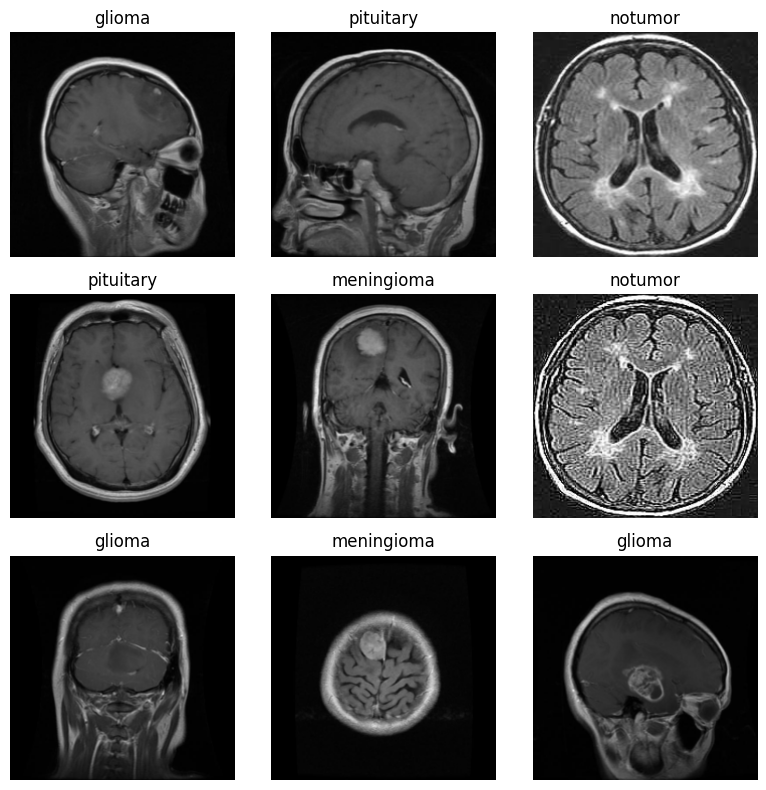

In [151]:
import random
import numpy as np

# Pick 9 random images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[idx]

    # Tensor → Numpy for plotting
    img = img.permute(1, 2, 0).numpy()
    
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()



In [152]:
from collections import Counter

# Folder-wise image counts
labels = [label for _, label in train_dataset]
counter = Counter(labels)

for i, c in enumerate(classes):
    print(f"{c}: {counter[i]} images")


glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


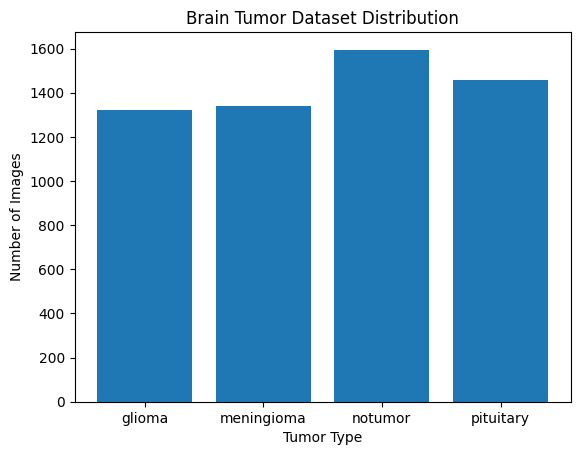

In [153]:
plt.bar(classes, [counter[i] for i in range(len(classes))])
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.title("Brain Tumor Dataset Distribution")
plt.show()


📦 Step 3: Make Datasets class

In [154]:
from torch.utils.data import DataLoader ,Dataset
from sklearn.model_selection import train_test_split



class CustomImageDataset(Dataset):
    def __init__(self, image_folder):
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        img, label = self.image_folder[idx]
        img = self.transform(img)
        return img, label

⚙️ Step 4: Create Dataloaders

In [155]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False,pin_memory=True)


🧩 Step 5: Make Model Convolutional Neural Neteork

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding='same', stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),  # corrected size
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [171]:
l=len(classes)

In [172]:
model = CNN(input_channels=3)
model.to(device)


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_featur

In [173]:
for param in model.parameters():
    print(param.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 100352])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])


In [174]:
learning_rate=0.001
epochs=10
batch_size=32

In [175]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [176]:
# criterion=nn.CrossEntropyLoss()
# optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [177]:
for epoch in range(epochs):
    total_epoch_loss = 0.0

    # iterate through batches
    for batch_features, batch_labels in train_loader:
        # Move the data to GPU (if available)
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = total_epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


Epoch [1/10] - Loss: 1.0664
Epoch [2/10] - Loss: 0.7230
Epoch [3/10] - Loss: 0.5706
Epoch [4/10] - Loss: 0.4836
Epoch [5/10] - Loss: 0.4244
Epoch [6/10] - Loss: 0.3860
Epoch [7/10] - Loss: 0.3510
Epoch [8/10] - Loss: 0.3223
Epoch [9/10] - Loss: 0.2958
Epoch [10/10] - Loss: 0.2682


In [178]:
model.eval()  # turn off dropout, batchnorm, etc.


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_featur

Accuracy Test on test data

In [179]:
correct = 0
total = 0

with torch.no_grad():  # no gradients needed
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 85.51%


Accuracy test on Test dataset

In [180]:
correct = 0
total = 0

with torch.no_grad():  # no gradients needed
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 91.91%


save model

In [182]:
# Save
torch.save(model, "model.pth")

# Load
model = torch.load("model.pth")
model.eval()

C:\Users\sande\AppData\Local\Temp\ipykernel_13588\486548531.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model.pth")


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_featur

In [183]:
from PIL import Image

# Define class names (in same order as your training labels)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Load model
model = torch.load("model.pth", map_location=torch.device('cpu'))
model.eval()

# Prediction function
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # add batch dimension

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    print(f"\n🧠 Predicted Tumor Type: {classes[predicted.item()]}")
    return classes[predicted.item()]

# Example usage
# predict("sample_mri.jpg")


C:\Users\sande\AppData\Local\Temp\ipykernel_13588\2845487532.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model.pth", map_location=torch.device('c

In [184]:
predict(r'D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Tr-gl_0011.jpg')
    


🧠 Predicted Tumor Type: glioma


'glioma'